# Part 5 Customer preference simulation and Modeling
In this notebook, we first simulated the customer's preferences for ideal houses using numpy random module. Each feature was assigned with a weight to show the importance for the customer's preference. We then calculated the score for each house and selected top ~20% for the customer. 
Finally, we built models to learn the preference using Logistic regression, Random Forest and Gradient Boosting. We compared these models using ROC/AUC and chose the best model (Gradient Boosting) for final optimization by tuning model parameters.

In [261]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import glob
import warnings
from sklearn.preprocessing import MinMaxScaler
import random
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 30)

In [262]:
#Loading data from previous part
df=pd.read_csv("df_visual_2.csv")

In [263]:
df

,beds,baths,sqft,solddate,soldprice,housetype,YearBuilt,Heating,Cooling,parking,name,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,lotsize1,pricepersqft,date,day,month,year,SHAPE,restaurants,schools,hospitals,gas_stations,parks,supermarkets
0,3,2.0,1478,4/22/2019,224778,Single Family,2000,Other,Central,2,"702 Le Ann Ln, Cedar Park, TX 78613",702 Le Ann Ln,Cedar Park,TX,78613,30.518779,-97.817411,5662.0,152.082544,4/22/2019,22,4,2019,"{'x': -97.817411, 'y': 30.518779, 'spatialRefe...",30,30,2,14,9,16
1,4,2.5,2665,4/12/2019,250000,Single Family,2000,Forced air,Central,1,"2605 Byfield Dr, Cedar Park, TX 78613",2605 Byfield Dr,Cedar Park,TX,78613,30.540536,-97.845924,8276.0,93.808630,4/12/2019,12,4,2019,"{'x': -97.845924, 'y': 30.540536, 'spatialRefe...",30,29,2,15,2,10
2,3,3.0,2255,4/5/2019,269000,Single Family,2000,Forced air,Central,2,"1622 Abbey Ln, Cedar Park, TX 78613",1622 Abbey Ln,Cedar Park,TX,78613,30.522559,-97.854897,7666.0,119.290466,4/5/2019,5,4,2019,"{'x': -97.854897, 'y': 30.522559, 'spatialRefe...",30,30,2,16,5,12
3,3,2.0,1820,3/22/2019,252883,Single Family,2000,Forced air,Central,2,"1007 Cashew Ln, Cedar Park, TX 78613",1007 Cashew Ln,Cedar Park,TX,78613,30.507623,-97.804945,8624.0,138.946703,3/22/2019,22,3,2019,"{'x': -97.804945, 'y': 30.507623, 'spatialRefe...",30,30,2,14,13,18
4,5,5.0,3608,3/1/2019,450000,Single Family,2000,Other,Central,3,"1818 Cattle Dr, Cedar Park, TX 78613",1818 Cattle Dr,Cedar Park,TX,78613,30.487773,-97.846532,8887.0,124.722838,3/1/2019,1,3,2019,"{'x': -97.846532, 'y': 30.487773, 'spatialRefe...",29,30,2,13,13,13
5,3,2.0,2054,2/19/2019,325000,Single Family,2000,Forced air,Central,3,"106 Cluck Creek Trl, Cedar Park, TX 78613",106 Cluck Creek Trl,Cedar Park,TX,78613,30.506421,-97.830857,8232.0,158.227848,2/19/2019,19,2,2019,"{'x': -97.830857, 'y': 30.506421000000003, 'sp...",30,30,2,14,10,16
6,5,3.0,3268,2/15/2019,372248,Single Family,2000,Forced air,Central,2,"2110 Rachel Rdg, Cedar Park, TX 78613",2110 Rachel Rdg,Cedar Park,TX,78613,30.486937,-97.850789,8842.0,113.906977,2/15/2019,15,2,2019,"{'x': -97.850789, 'y': 30.486937, 'spatialRefe...",29,30,2,13,12,12
7,3,2.0,1820,12/20/2018,257852,Single Family,2000,Forced air,Central,2,"602 S Lynnwood Trl, Cedar Park, TX 78613",602 S Lynnwood Trl,Cedar Park,TX,78613,30.507676,-97.803343,8712.0,141.676923,12/20/2018,20,12,2018,"{'x': -97.803343, 'y': 30.507676, 'spatialRefe...",30,30,2,14,13,18
8,4,2.0,1825,12/12/2018,240263,Single Family,2000,Forced air,Central,2,"718 Le Ann Ln, Cedar Park, TX 78613",718 Le Ann Ln,Cedar Park,TX,78613,30.519679,-97.818170,5445.0,131.650959,12/12/2018,12,12,2018,"{'x': -97.81817, 'y': 30.519679, 'spatialRefer...",30,30,2,15,9,16
9,3,2.5,2846,11/26/2018,272942,Single Family,2000,Forced air,Central,1,"1037 Silverstone Ln, Cedar Park, TX 78613",1037 Silverstone Ln,Cedar Park,TX,78613,30.519607,-97.844708,6577.0,95.903725,11/26/2018,26,11,2018,"{'x': -97.844708, 'y': 30.519607, 'spatialRefe...",30,30,2,16,5,15


Before modeling, we scaled the numeric columns using Min-max method. Without this, the model or score will be biased toward features with high values such as price and lot size. 

In [264]:
#Select columns needed for modeling
dfmodel=df.loc[:,['beds', 'baths', 'sqft', 'soldprice',
       'YearBuilt', 'Heating', 'Cooling', 'parking','lotsize1',
       'restaurants', 'schools', 'hospitals', 'gas_stations', 'parks','supermarkets']]


columns_to_scale = ['beds', 'baths', 'sqft', 'soldprice','YearBuilt','lotsize1','restaurants', 
                    'schools', 'hospitals', 'gas_stations', 'parks','supermarkets']

#Minmaxscaler to scale numeric columns
Scaler = MinMaxScaler()

columns_scaled = Scaler.fit_transform(dfmodel[columns_to_scale])
dfmodel_scaled = pd.DataFrame(columns_scaled, columns=columns_to_scale)
dfmodel_scaled = pd.concat([dfmodel_scaled, df.loc[:,['Heating', 'Cooling', 'parking']]], axis=1, sort=False)
dfmodel_scaled.head()

,beds,baths,sqft,soldprice,YearBuilt,lotsize1,restaurants,schools,hospitals,gas_stations,parks,supermarkets,Heating,Cooling,parking
0,0.2,0.090909,0.059609,0.031131,0.0,0.009058,1.000000,1.000000,0.333333,0.8125,0.321429,0.592593,Other,Central,2
1,0.4,0.181818,0.206406,0.042288,0.0,0.014242,1.000000,0.966667,0.333333,0.8750,0.071429,0.370370,Forced air,Central,1
2,0.2,0.272727,0.155701,0.050693,0.0,0.013033,1.000000,1.000000,0.333333,0.9375,0.178571,0.444444,Forced air,Central,2
3,0.2,0.090909,0.101905,0.043564,0.0,0.014933,1.000000,1.000000,0.333333,0.8125,0.464286,0.666667,Forced air,Central,2
4,0.6,0.636364,0.323027,0.130761,0.0,0.015454,0.966667,1.000000,0.333333,0.7500,0.464286,0.481481,Other,Central,3


We use **np.random.choice** to randomly select customer's preference for each feature using different approaches.
  * Assign different probabilities to preferred number: bedrooms, bathrooms
  * Assign preferred range using min,25%,median,75%,max: sqft, lotsize, price, year built
  * Assign preferred type using the feature's frequency: Heating, Cooling, parking
 
Preference weights
  * Multiply with a positive constant if the feature is within preferred range
  * Multiply with a negative constant or 0 if outside the range.

In [265]:
#Simulte user prefereces and assign weight to each feature

np.random.seed(0)

beds=np.random.choice(np.sort(dfmodel_scaled.beds.unique()),p=[0.3,0.3,0.2,0.1,0.05,0.05])
print("Perferred bedrooms: {}".format(round(beds*(df.beds.unique().max()-df.beds.unique().min())+df.beds.unique().min(),1)))
dfmodel_scaled["beds_score"]=np.where(dfmodel_scaled["beds"]>=beds,dfmodel_scaled["beds"]*1,0)


baths=np.random.choice(np.sort(dfmodel_scaled.baths.unique()),p=[0.05,0.3,0.2,0.2,0.1,0.1,0.01,0.01,0.01,0.01,0.01])
print("Perferred bathrooms: {}".format(round(baths*(df.baths.unique().max()-df.baths.unique().min())+df.baths.unique().min(),1)))
dfmodel_scaled["baths_score"]=np.where(dfmodel_scaled["baths"]>=baths,dfmodel_scaled["baths"]*1,0)


sqft=np.random.choice(dfmodel_scaled.sqft.describe().drop(["count","mean","std"]), size=2, replace=False)
print("Perferred size from {} sqft to {} sqft".format(
        int(sqft.min()*(df.sqft.unique().max()-df.sqft.unique().min())+df.sqft.unique().min()),
      int(sqft.max()*(df.sqft.unique().max()-df.sqft.unique().min())+df.sqft.unique().min())))
dfmodel_scaled["sqft_score"]=np.where((dfmodel_scaled["sqft"]>=sqft.min())&(dfmodel_scaled["sqft"]<=sqft.max()),dfmodel_scaled["sqft"]*1,0)



lotsize1=np.random.choice(dfmodel_scaled.lotsize1.describe().drop(["count","mean","std"]), size=2, replace=False)
print("Perferred lot size from {} sqft to {} sqft".format(
        int(lotsize1.min()*(df.lotsize1.unique().max()-df.lotsize1.unique().min())+df.lotsize1.unique().min()),
      int(lotsize1.max()*(df.lotsize1.unique().max()-df.lotsize1.unique().min())+df.lotsize1.unique().min())))
dfmodel_scaled["lotsize1_score"]=np.where((dfmodel_scaled["lotsize1"]>=lotsize1.min())&(dfmodel_scaled["lotsize1"]<=lotsize1.max()),dfmodel_scaled["lotsize1"]*1,0)



price=np.random.choice(dfmodel_scaled.soldprice.describe().drop(["count","mean","std","max","min"]))
print("Perferred price: {}".format(int(price*(df.soldprice.unique().max()-df.soldprice.unique().min())+df.soldprice.unique().min())))
dfmodel_scaled["soldprice_score"]=np.where(dfmodel_scaled["soldprice"]>price,dfmodel_scaled["soldprice"]*(-2),0)



year=np.random.choice(dfmodel_scaled.YearBuilt.describe().drop(["count","mean","std","max"]))
print("Perferred year built: from {}".format(int(year*(df.YearBuilt.unique().max()-df.YearBuilt.unique().min())+df.YearBuilt.unique().min())))
dfmodel_scaled["year_score"]=np.where(dfmodel_scaled["YearBuilt"]>=year,dfmodel_scaled["YearBuilt"]*1.5,0)



Heating=np.random.choice(df.Heating.unique(),p=list(df.Heating.value_counts()/len(df)), size=2, replace=False)
print("Heating:  {}".format(Heating))

Cooling=np.random.choice(df.Cooling.unique(),p=list(df.Cooling.value_counts()/len(df)), size=2, replace=False)
print("Cooling:  {}".format(Cooling))

parking=np.random.choice(df.parking.unique(),p=list(df.parking.value_counts()/len(df)), size=2, replace=False)
print("Parking:  {}".format(parking))


dfmodel_scaled["restaurants_score"]=dfmodel_scaled["restaurants"]*1.5
dfmodel_scaled["schools_score"]=dfmodel_scaled["schools"]*1.5
dfmodel_scaled["hospitals_score"]=dfmodel_scaled["hospitals"]*1.5
dfmodel_scaled["gas_stations_score"]=dfmodel_scaled["gas_stations"]*1
dfmodel_scaled["parks_score"]=dfmodel_scaled["parks"]*1
dfmodel_scaled["supermarkets_score"]=dfmodel_scaled["supermarkets"]*1.5


dfmodel_scaled["Total Score"]=dfmodel_scaled.loc[:,"beds_score":"supermarkets_score"].sum(axis=1)


dfmodel_scaled

Perferred bedrooms: 3.0
Perferred bathrooms: 3.0
Perferred size from 996 sqft to 2402 sqft
Perferred lot size from 6881 sqft to 9234 sqft
Perferred price: 362194
Perferred year built: from 2000
Heating:  ['Other' 'Forced air']
Cooling:  ['Central' 'Other']
Parking:  ['2' '1']


,beds,baths,sqft,soldprice,YearBuilt,lotsize1,restaurants,schools,hospitals,gas_stations,parks,supermarkets,Heating,Cooling,parking,beds_score,baths_score,sqft_score,lotsize1_score,soldprice_score,year_score,restaurants_score,schools_score,hospitals_score,gas_stations_score,parks_score,supermarkets_score,Total Score
0,0.2,0.090909,0.059609,0.031131,0.000000,0.009058,1.000000,1.000000,0.333333,0.8125,0.321429,0.592593,Other,Central,2,0.2,0.000000,0.059609,0.000000,0.000000,0.000000,1.50,1.50,0.5,0.8125,0.321429,0.888889,5.782427
1,0.4,0.181818,0.206406,0.042288,0.000000,0.014242,1.000000,0.966667,0.333333,0.8750,0.071429,0.370370,Forced air,Central,1,0.4,0.000000,0.000000,0.014242,0.000000,0.000000,1.50,1.45,0.5,0.8750,0.071429,0.555556,5.366226
2,0.2,0.272727,0.155701,0.050693,0.000000,0.013033,1.000000,1.000000,0.333333,0.9375,0.178571,0.444444,Forced air,Central,2,0.2,0.272727,0.155701,0.013033,0.000000,0.000000,1.50,1.50,0.5,0.9375,0.178571,0.666667,5.924199
3,0.2,0.090909,0.101905,0.043564,0.000000,0.014933,1.000000,1.000000,0.333333,0.8125,0.464286,0.666667,Forced air,Central,2,0.2,0.000000,0.101905,0.014933,0.000000,0.000000,1.50,1.50,0.5,0.8125,0.464286,1.000000,6.093623
4,0.6,0.636364,0.323027,0.130761,0.000000,0.015454,0.966667,1.000000,0.333333,0.7500,0.464286,0.481481,Other,Central,3,0.6,0.636364,0.000000,0.015454,-0.261521,0.000000,1.45,1.50,0.5,0.7500,0.464286,0.722222,6.376805
5,0.2,0.090909,0.130843,0.075465,0.000000,0.014155,1.000000,1.000000,0.333333,0.8125,0.357143,0.592593,Forced air,Central,3,0.2,0.000000,0.130843,0.014155,0.000000,0.000000,1.50,1.50,0.5,0.8125,0.357143,0.888889,5.903530
6,0.6,0.272727,0.280979,0.096366,0.000000,0.015365,0.966667,1.000000,0.333333,0.7500,0.428571,0.444444,Forced air,Central,2,0.6,0.272727,0.000000,0.015365,-0.192732,0.000000,1.45,1.50,0.5,0.7500,0.428571,0.666667,5.990598
7,0.2,0.090909,0.101905,0.045762,0.000000,0.015107,1.000000,1.000000,0.333333,0.8125,0.464286,0.666667,Forced air,Central,2,0.2,0.000000,0.101905,0.015107,0.000000,0.000000,1.50,1.50,0.5,0.8125,0.464286,1.000000,6.093797
8,0.4,0.090909,0.102523,0.037981,0.000000,0.008628,1.000000,1.000000,0.333333,0.8750,0.321429,0.592593,Forced air,Central,2,0.4,0.000000,0.102523,0.000000,0.000000,0.000000,1.50,1.50,0.5,0.8750,0.321429,0.888889,6.087840
9,0.2,0.181818,0.228791,0.052437,0.000000,0.010873,1.000000,1.000000,0.333333,0.9375,0.178571,0.555556,Forced air,Central,1,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,1.50,1.50,0.5,0.9375,0.178571,0.833333,5.649405


count    5308.000000
mean        5.224489
std         1.164413
min         0.178065
25%         4.379236
50%         5.446825
75%         6.065697
max         8.235419
Name: Total Score, dtype: float64

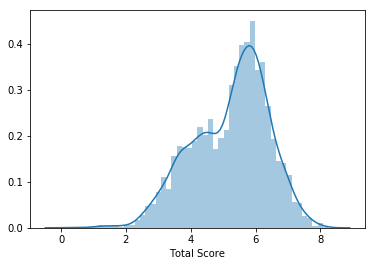

In [266]:
sns.distplot(dfmodel_scaled["Total Score"], bins=50);
dfmodel_scaled["Total Score"].describe()

In [267]:
# Select data with top 25% score and also match customer's preferences for Heating,Cooling and Parking. 
# Make all matched data to be 1, else 0
dfmodel_scaled["decision"]=np.where(

(dfmodel_scaled["Total Score"]>dfmodel_scaled["Total Score"].describe()[-2])&\
(dfmodel_scaled["Heating"].isin(Heating))&\
(dfmodel_scaled["Cooling"].isin(Cooling))&\
(dfmodel_scaled["parking"].isin(parking)),
    1,0
)


In [270]:
print ("{}% of houses match preference and are chosen as 1".format (round(dfmodel_scaled["decision"].sum()/len(dfmodel_scaled["decision"]),2)*100))

20.0% of houses match preference and are chosen as 1


In [271]:
dfmodel_scaled.head(10)

,beds,baths,sqft,soldprice,YearBuilt,lotsize1,restaurants,schools,hospitals,gas_stations,parks,supermarkets,Heating,Cooling,parking,beds_score,baths_score,sqft_score,lotsize1_score,soldprice_score,year_score,restaurants_score,schools_score,hospitals_score,gas_stations_score,parks_score,supermarkets_score,Total Score,decision
0,0.2,0.090909,0.059609,0.031131,0.0,0.009058,1.000000,1.000000,0.333333,0.8125,0.321429,0.592593,Other,Central,2,0.2,0.000000,0.059609,0.000000,0.000000,0.0,1.50,1.50,0.5,0.8125,0.321429,0.888889,5.782427,0
1,0.4,0.181818,0.206406,0.042288,0.0,0.014242,1.000000,0.966667,0.333333,0.8750,0.071429,0.370370,Forced air,Central,1,0.4,0.000000,0.000000,0.014242,0.000000,0.0,1.50,1.45,0.5,0.8750,0.071429,0.555556,5.366226,0
2,0.2,0.272727,0.155701,0.050693,0.0,0.013033,1.000000,1.000000,0.333333,0.9375,0.178571,0.444444,Forced air,Central,2,0.2,0.272727,0.155701,0.013033,0.000000,0.0,1.50,1.50,0.5,0.9375,0.178571,0.666667,5.924199,0
3,0.2,0.090909,0.101905,0.043564,0.0,0.014933,1.000000,1.000000,0.333333,0.8125,0.464286,0.666667,Forced air,Central,2,0.2,0.000000,0.101905,0.014933,0.000000,0.0,1.50,1.50,0.5,0.8125,0.464286,1.000000,6.093623,1
4,0.6,0.636364,0.323027,0.130761,0.0,0.015454,0.966667,1.000000,0.333333,0.7500,0.464286,0.481481,Other,Central,3,0.6,0.636364,0.000000,0.015454,-0.261521,0.0,1.45,1.50,0.5,0.7500,0.464286,0.722222,6.376805,0
5,0.2,0.090909,0.130843,0.075465,0.0,0.014155,1.000000,1.000000,0.333333,0.8125,0.357143,0.592593,Forced air,Central,3,0.2,0.000000,0.130843,0.014155,0.000000,0.0,1.50,1.50,0.5,0.8125,0.357143,0.888889,5.903530,0
6,0.6,0.272727,0.280979,0.096366,0.0,0.015365,0.966667,1.000000,0.333333,0.7500,0.428571,0.444444,Forced air,Central,2,0.6,0.272727,0.000000,0.015365,-0.192732,0.0,1.45,1.50,0.5,0.7500,0.428571,0.666667,5.990598,0
7,0.2,0.090909,0.101905,0.045762,0.0,0.015107,1.000000,1.000000,0.333333,0.8125,0.464286,0.666667,Forced air,Central,2,0.2,0.000000,0.101905,0.015107,0.000000,0.0,1.50,1.50,0.5,0.8125,0.464286,1.000000,6.093797,1
8,0.4,0.090909,0.102523,0.037981,0.0,0.008628,1.000000,1.000000,0.333333,0.8750,0.321429,0.592593,Forced air,Central,2,0.4,0.000000,0.102523,0.000000,0.000000,0.0,1.50,1.50,0.5,0.8750,0.321429,0.888889,6.087840,1
9,0.2,0.181818,0.228791,0.052437,0.0,0.010873,1.000000,1.000000,0.333333,0.9375,0.178571,0.555556,Forced air,Central,1,0.2,0.000000,0.000000,0.000000,0.000000,0.0,1.50,1.50,0.5,0.9375,0.178571,0.833333,5.649405,0


# Prepare data for modeling

In [247]:
#Combine decision to original data
dfmodel_decision=pd.concat([dfmodel, dfmodel_scaled['decision']], axis=1, sort=False)
dfmodel_decision.head(5)

,beds,baths,sqft,soldprice,YearBuilt,Heating,Cooling,parking,lotsize1,restaurants,schools,hospitals,gas_stations,parks,supermarkets,decision
0,3,2.0,1478,224778,2000,Other,Central,2,5662.0,30,30,2,14,9,16,0
1,4,2.5,2665,250000,2000,Forced air,Central,1,8276.0,30,29,2,15,2,10,0
2,3,3.0,2255,269000,2000,Forced air,Central,2,7666.0,30,30,2,16,5,12,0
3,3,2.0,1820,252883,2000,Forced air,Central,2,8624.0,30,30,2,14,13,18,1
4,5,5.0,3608,450000,2000,Other,Central,3,8887.0,29,30,2,13,13,13,0


In [248]:
#one hot encoding for categorical variables
dfmodel_decision_d=pd.get_dummies(dfmodel_decision.loc[:,['Heating','Cooling','parking']])
dfmodel_decision_d.head(5)

,Heating_Forced air,Heating_Heat pump,Heating_No Data,Heating_Other,Cooling_Central,Cooling_No Data,Cooling_Other,parking_1,parking_2,parking_3,parking_4+,parking_Attached-Detached-Carport,parking_No Data
0,0,0,0,1,1,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,1,0,0,0,0,0
2,1,0,0,0,1,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,1,1,0,0,0,0,1,0,0,0


In [249]:
columns_to_scale = ['beds', 'baths', 'sqft', 'soldprice','YearBuilt','lotsize1','restaurants', 
                    'schools', 'hospitals', 'gas_stations', 'parks','supermarkets']

dfmodel_decision_final = pd.concat([dfmodel_decision[columns_to_scale], dfmodel_decision_d], axis=1, sort=False)
dfmodel_decision_final.head(5)

,beds,baths,sqft,soldprice,YearBuilt,lotsize1,restaurants,schools,hospitals,gas_stations,parks,supermarkets,Heating_Forced air,Heating_Heat pump,Heating_No Data,Heating_Other,Cooling_Central,Cooling_No Data,Cooling_Other,parking_1,parking_2,parking_3,parking_4+,parking_Attached-Detached-Carport,parking_No Data
0,3,2.0,1478,224778,2000,5662.0,30,30,2,14,9,16,0,0,0,1,1,0,0,0,1,0,0,0,0
1,4,2.5,2665,250000,2000,8276.0,30,29,2,15,2,10,1,0,0,0,1,0,0,1,0,0,0,0,0
2,3,3.0,2255,269000,2000,7666.0,30,30,2,16,5,12,1,0,0,0,1,0,0,0,1,0,0,0,0
3,3,2.0,1820,252883,2000,8624.0,30,30,2,14,13,18,1,0,0,0,1,0,0,0,1,0,0,0,0
4,5,5.0,3608,450000,2000,8887.0,29,30,2,13,13,13,0,0,0,1,1,0,0,0,0,1,0,0,0


# Split Data into train and test set for modeling

In [250]:
# 75% train and 25% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfmodel_decision_final, dfmodel_decision["decision"], random_state=0)
(len(X_train), len(X_test))

(3981, 1327)

In [251]:
columns_to_scale = ['beds', 'baths', 'sqft', 'soldprice','YearBuilt','lotsize1','restaurants', 
                    'schools', 'hospitals', 'gas_stations', 'parks','supermarkets']
Scaler = MinMaxScaler()
dfmodel_decision_scaled_train = Scaler.fit_transform(X_train[columns_to_scale])
dfmodel_decision_scaled_test = Scaler.transform(X_test[columns_to_scale])

dfmodel_decision_scaled_train = pd.DataFrame(dfmodel_decision_scaled_train, columns=columns_to_scale)
dfmodel_decision_scaled_test = pd.DataFrame(dfmodel_decision_scaled_test, columns=columns_to_scale)

train_d=pd.DataFrame(X_train.loc[:,'Heating_Forced air':])
train_d.reset_index(inplace = True, drop = True)
X_train = pd.concat([dfmodel_decision_scaled_train, train_d], axis=1, sort=False)


test_d=pd.DataFrame(X_test.loc[:,'Heating_Forced air':])
test_d.reset_index(inplace = True, drop = True)
X_test = pd.concat([dfmodel_decision_scaled_test, test_d], axis=1, sort=False)

In [252]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc

We first used Logistic regression, Random forest and Gradient Boosting to check test accuracy using 10-fold cross validation without tuning the paramters. Gradient Boosting shows highest accuracy among all 3 models. Parameters were tuned to optimize Gradient Boosting performance.

# Logistic regression

Logistic model shows 95.7% accuracy. The coef for each feature is different from the weights assigned earlier. It is probably because we didn't assign weight to Heating, Cooling and Parking types when we did the scoring.

In [253]:
Logistic = LogisticRegression()

scores= cross_val_score(Logistic, X_train, y_train,cv=10, scoring ="accuracy");
print("Logistic Accuracy with 95% confidence interval: \
{:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std() * 2))

Logistic Accuracy with 95% confidence interval: 0.95 (+/- 0.02)


In [254]:
Logistic = LogisticRegression().fit(X_train, y_train)
print(Logistic.score(X_test, y_test))
pd.crosstab(y_test,Logistic.predict(X_test),rownames=['True'], colnames=["Logisticpre"])

0.9570459683496609


Logisticpre,0,1
True,,
0,1066,14
1,43,204


In [255]:
list(zip(X_train.columns, list(Logistic.coef_.round(2)[0])))

[('beds', 2.04),
 ('baths', 3.88),
 ('sqft', -1.22),
 ('soldprice', -0.7),
 ('YearBuilt', 4.7),
 ('lotsize1', -0.39),
 ('restaurants', -2.81),
 ('schools', 1.74),
 ('hospitals', 6.25),
 ('gas_stations', 5.24),
 ('parks', 4.34),
 ('supermarkets', 5.59),
 ('Heating_Forced air', -1.65),
 ('Heating_Heat pump', -4.79),
 ('Heating_No Data', -1.45),
 ('Heating_Other', -1.52),
 ('Cooling_Central', -1.89),
 ('Cooling_No Data', -5.96),
 ('Cooling_Other', -1.56),
 ('parking_1', 1.1),
 ('parking_2', 1.24),
 ('parking_3', -4.35),
 ('parking_4+', -3.44),
 ('parking_Attached-Detached-Carport', -2.72),
 ('parking_No Data', -1.24)]

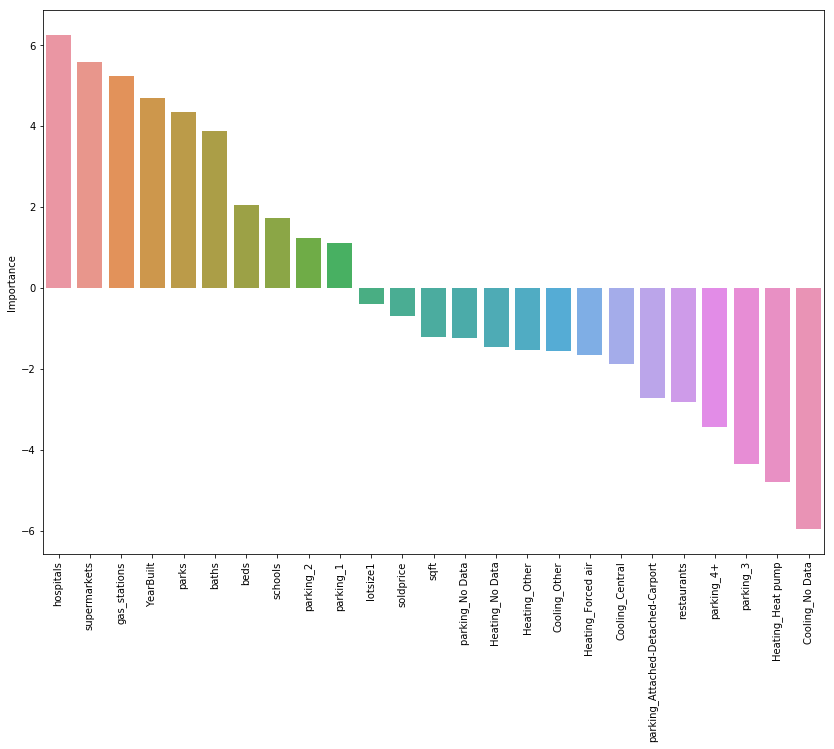

In [272]:
plt.figure(figsize=(14,10))
importance = Logistic.coef_.round(2)[0]
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])

importance = importance.sort_values(by="Importance",ascending=False)
sns.barplot(importance.index, importance.Importance)
plt.xticks(rotation="vertical");


# Random Forest
Random Forest model shows 95.4% accuracy, which is slightly lower than Logistic mode. The top 3 important features are supermarkets, parks and year built. 

In [277]:
random_forest =RandomForestClassifier(n_estimators=100,random_state = 0)
scores= cross_val_score(random_forest, X_train, y_train,cv=10, scoring ="accuracy")
print("Random_forest Accuracy with 95% confidence interval: \
{:0.2f} (+/- {:0.2f})".format(scores.mean(), scores.std() * 2))

Random_forest Accuracy with 95% confidence interval: 0.95 (+/- 0.01)


In [279]:
random_forest =RandomForestClassifier(n_estimators=100,random_state = 0).fit(X_train, y_train)
print(random_forest.score(X_test, y_test))
pd.crosstab(y_test,random_forest.predict(X_test),rownames=['True'], colnames=["random_forest"])

0.9540316503391107


random_forest,0,1
True,,
0,1061,19
1,42,205


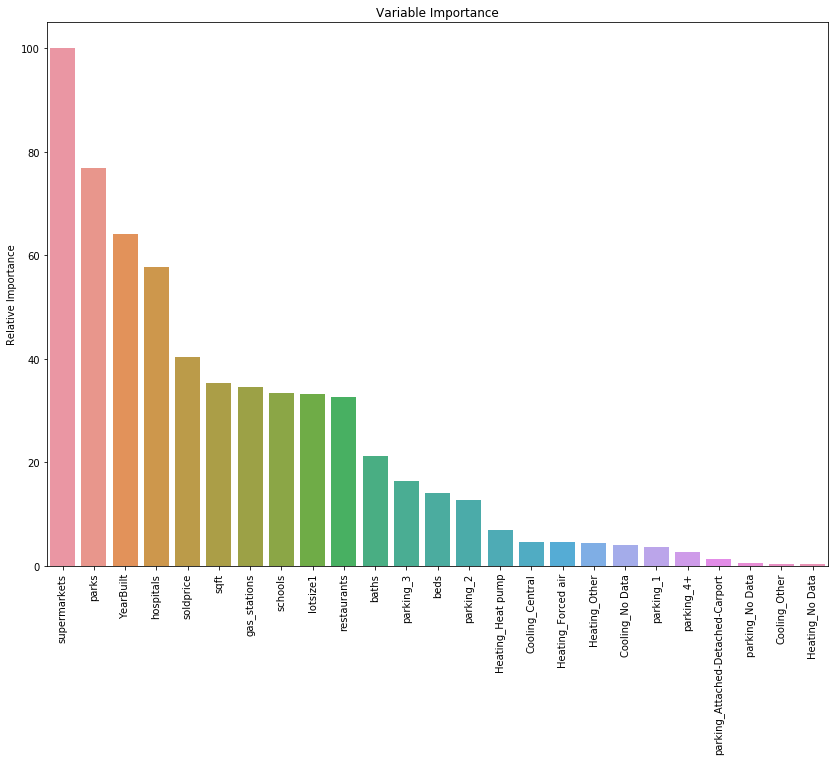

In [280]:
plt.figure(figsize=(14,10))
importance = random_forest.feature_importances_
importance = pd.DataFrame(100.0 * (importance/ importance.max()), index=X_train.columns, 
                          columns=["Importance"])

importance = importance.sort_values(by="Importance",ascending=False)
sns.barplot(importance.index, importance.Importance)
plt.xticks(rotation="vertical")
plt.ylabel('Relative Importance')
plt.title('Variable Importance');

# Gradient Boosting

Gradient booting shows slightly higher than Logistic and Random Forest. The top 3 important features are supermarkets, year built and hospitals, which are similar to Random Forest. Since Gradient booting shows highest accuracy so far and it is possible to further optimize the accuracy, we will choose it for parameter tuning.

In [281]:
from sklearn.ensemble import GradientBoostingClassifier

GradientBoosting = GradientBoostingClassifier(random_state = 0)
GradientBoosting.fit(X_train, y_train)
GradientBoosting.score(X_test, y_test)

0.9585531273549359

In [282]:
GradientBoosting = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)
print(GradientBoosting.score(X_test, y_test))
pd.crosstab(y_test,GradientBoosting.predict(X_test),rownames=['True'], colnames=["GradientBoosting"])

0.9585531273549359


GradientBoosting,0,1
True,,
0,1062,18
1,37,210


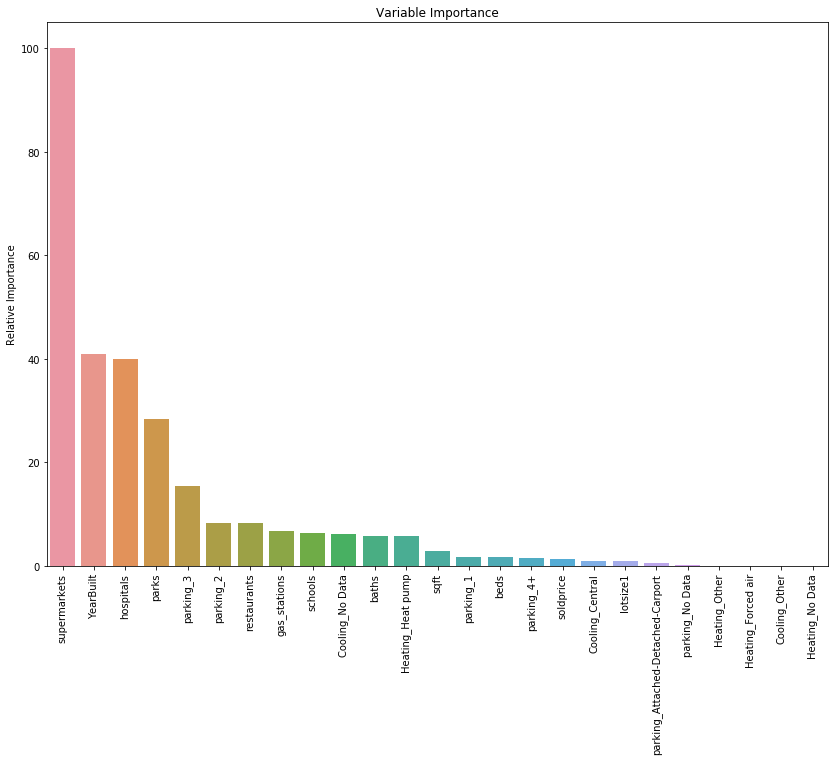

In [283]:
plt.figure(figsize=(14,10))
importance = GradientBoosting.feature_importances_
importance = pd.DataFrame(100.0 * (importance/ importance.max()), index=X_train.columns, 
                          columns=["Importance"])

importance = importance.sort_values(by="Importance",ascending=False)
sns.barplot(importance.index, importance.Importance)
plt.xticks(rotation="vertical")
plt.ylabel('Relative Importance')
plt.title('Variable Importance');

# ROC

Logistic Regression AUC score:0.9900584795321637
RandomForest AUC score:0.9843436047383416
Gradient Boosting AUC score:0.988392187734293


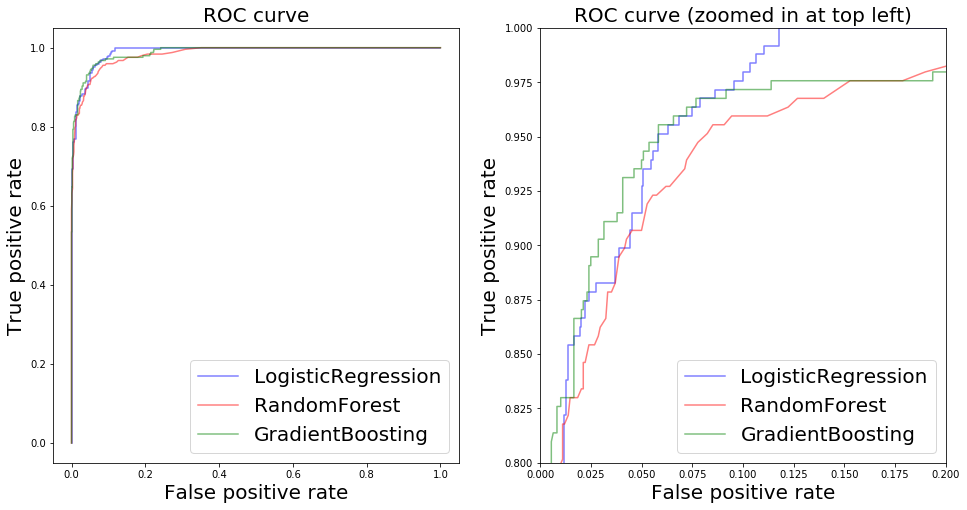

In [284]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
y_proba_lg = Logistic.predict_proba(X_test)
y_proba_RF = random_forest.predict_proba(X_test)
y_proba_GB = GradientBoosting.predict_proba(X_test)
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_proba_lg[:,1])
plt.plot(fpr_lg, tpr_lg, color='b', alpha=0.5,label="LogisticRegression")
plt.xlabel('False positive rate',fontsize=20)
plt.ylabel('True positive rate',fontsize=20)
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.title('ROC curve',fontsize=20)

fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_proba_RF[:,1])
plt.plot(fpr_RF,tpr_RF,  color='r', alpha=0.5,label="RandomForest")


fpr_GB, tpr_GB, thresholds_GB = roc_curve(y_test, y_proba_GB[:,1])
plt.plot(fpr_GB, tpr_GB, color='g', alpha=0.5,label="GradientBoosting");

#plt.legend(loc="lower left",fontsize=20)
plt.legend(loc='best',fontsize=20);



plt.subplot(1, 2, 2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lg, tpr_lg, color='b', alpha=0.5,label="LogisticRegression")
plt.plot(fpr_RF,tpr_RF,  color='r', alpha=0.5,label="RandomForest")
plt.plot(fpr_GB, tpr_GB, color='g', alpha=0.5,label="GradientBoosting");
plt.xlabel('False positive rate',fontsize=20)
plt.ylabel('True positive rate',fontsize=20)

plt.title('ROC curve (zoomed in at top left)',fontsize=20)
plt.legend(loc='best',fontsize=20);


print("Logistic Regression AUC score:{}".format(auc(fpr_lg, tpr_lg)))
print("RandomForest AUC score:{}".format(auc(fpr_RF, tpr_RF)))
print("Gradient Boosting AUC score:{}".format(auc(fpr_GB, tpr_GB)))

# Gradient Boosting Tuning
Below shows the 3 parameters tuned for better performance.
1. Learning rate: the higher value, the higher contribution of each tree. Default is 0.1
2. Max_depth: the depth of each tree. Default is 3
3. n_estimators: the number of trees. Default is 100

**Accuray**:
The result shows the best accuracy of Gradient Boosting is 97.7% when learning_rate=0.5, max_depth=1, n_estimators=1000. The accuracy is improved by 1.8% compared non-tuned model.

**Recall**:
We also noticed that False Negatives are significantly reduced from 37 to 13 and the recall is increased from 85% to 94.7%. This suggests the tuned model gives higher percentage of correct houses to customer preference.

**Precision**:
Since TP is increased from 210 to 234 with FP remains constant (18), precision is also improved from 92.1% to 92.8%.
This suggest, a given set of recommended house, there is 92.8% chance that meets what the customer wants.

**ROC**:
We can see an obvious improvement in Gradient Boosting ROC compared to the other two

In [288]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
    "max_depth":[1,2,3,5,8],
    "n_estimators":[1, 10, 50, 100, 200,500,1000]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, scoring ="accuracy")

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.9766390354182366
{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 1000}


In [289]:
GradientBoosting = GradientBoostingClassifier(learning_rate=0.5,max_depth=1,n_estimators=1000,random_state = 0).fit(X_train, y_train)
print(GradientBoosting.score(X_test, y_test))
pd.crosstab(y_test,GradientBoosting.predict(X_test),rownames=['True'], colnames=["GradientBoosting"])

0.9766390354182366


GradientBoosting,0,1
True,,
0,1062,18
1,13,234


Logistic Regression AUC score:0.9900584795321637
RandomForest AUC score:0.9843436047383416
Gradient Boosting AUC score:0.9976795621532464


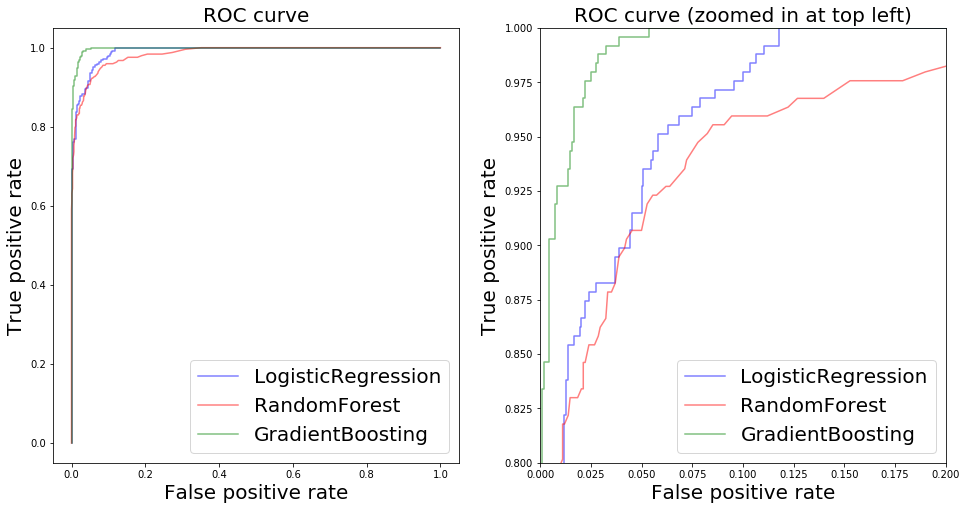

In [290]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
y_proba_lg = Logistic.predict_proba(X_test)
y_proba_RF = random_forest.predict_proba(X_test)
y_proba_GB = GradientBoosting.predict_proba(X_test)
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_test, y_proba_lg[:,1])
plt.plot(fpr_lg, tpr_lg, color='b', alpha=0.5,label="LogisticRegression")
plt.xlabel('False positive rate',fontsize=20)
plt.ylabel('True positive rate',fontsize=20)
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
plt.title('ROC curve',fontsize=20)

fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_proba_RF[:,1])
plt.plot(fpr_RF,tpr_RF,  color='r', alpha=0.5,label="RandomForest")


fpr_GB, tpr_GB, thresholds_GB = roc_curve(y_test, y_proba_GB[:,1])
plt.plot(fpr_GB, tpr_GB, color='g', alpha=0.5,label="GradientBoosting");

#plt.legend(loc="lower left",fontsize=20)
plt.legend(loc='best',fontsize=20);



plt.subplot(1, 2, 2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lg, tpr_lg, color='b', alpha=0.5,label="LogisticRegression")
plt.plot(fpr_RF,tpr_RF,  color='r', alpha=0.5,label="RandomForest")
plt.plot(fpr_GB, tpr_GB, color='g', alpha=0.5,label="GradientBoosting");
plt.xlabel('False positive rate',fontsize=20)
plt.ylabel('True positive rate',fontsize=20)

plt.title('ROC curve (zoomed in at top left)',fontsize=20)
plt.legend(loc='best',fontsize=20);


print("Logistic Regression AUC score:{}".format(auc(fpr_lg, tpr_lg)))
print("RandomForest AUC score:{}".format(auc(fpr_RF, tpr_RF)))
print("Gradient Boosting AUC score:{}".format(auc(fpr_GB, tpr_GB)))

# Summary

This procject shows the procedures to build a house recommedation system to best meet customer's preferences for buying houses in Austin areas.
We first collected all house features using web scraping from real estate website. Then we did data cleaning including missing data and outlier treatment followed by exploratory analysis. We also added features such as restaurants that allows more options for scoring in later part. 
In notebook part 4, we simulated the preferences for selecting desired houses with differnt weights to each feature.
Finally, 3 machine learning models were used to model the preference. After optimizing the best model, 97.7% accuracy along with 94.7% recall and 92.8% precision were achieved. This result shows that a good house recommedation model is built.

# Future work
We can include more data such as crime rate, net increase in moving-in population, companies since they are also important feature when people are looking for houses. We can also collect buyer reviews and do text analysis to see which regions are better.